In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline
from ovejero import model_trainer, hierarchical_inference
from multiprocessing import Pool
from matplotlib.lines import Line2D
import corner
import pandas as pd
import numpy as np
from lenstronomy.Util.param_util import ellipticity2phi_q

# This allows you to modify the paths in the config to agree with the path you're using
def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/',root_path)
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])

# Generating Hierarchical Inference Plots

__Author:__ Sebastian Wagner-Carena

__Last Run:__ 07/03/2020

__Goals:__ Generate all of the hierarchical inference plots used in the paper analysis.

__Before running this notebook:__ You will have to download and unzip the bnn samples, chains, and datasets that cound be found here (TODO). Because we already have the BNN samples, the model weights are not neccesary. If you would like to reproduce these results starting from the model weights, see the demo notebook on hierarchical inference.

## Create a corner plot to compare training and test distributions

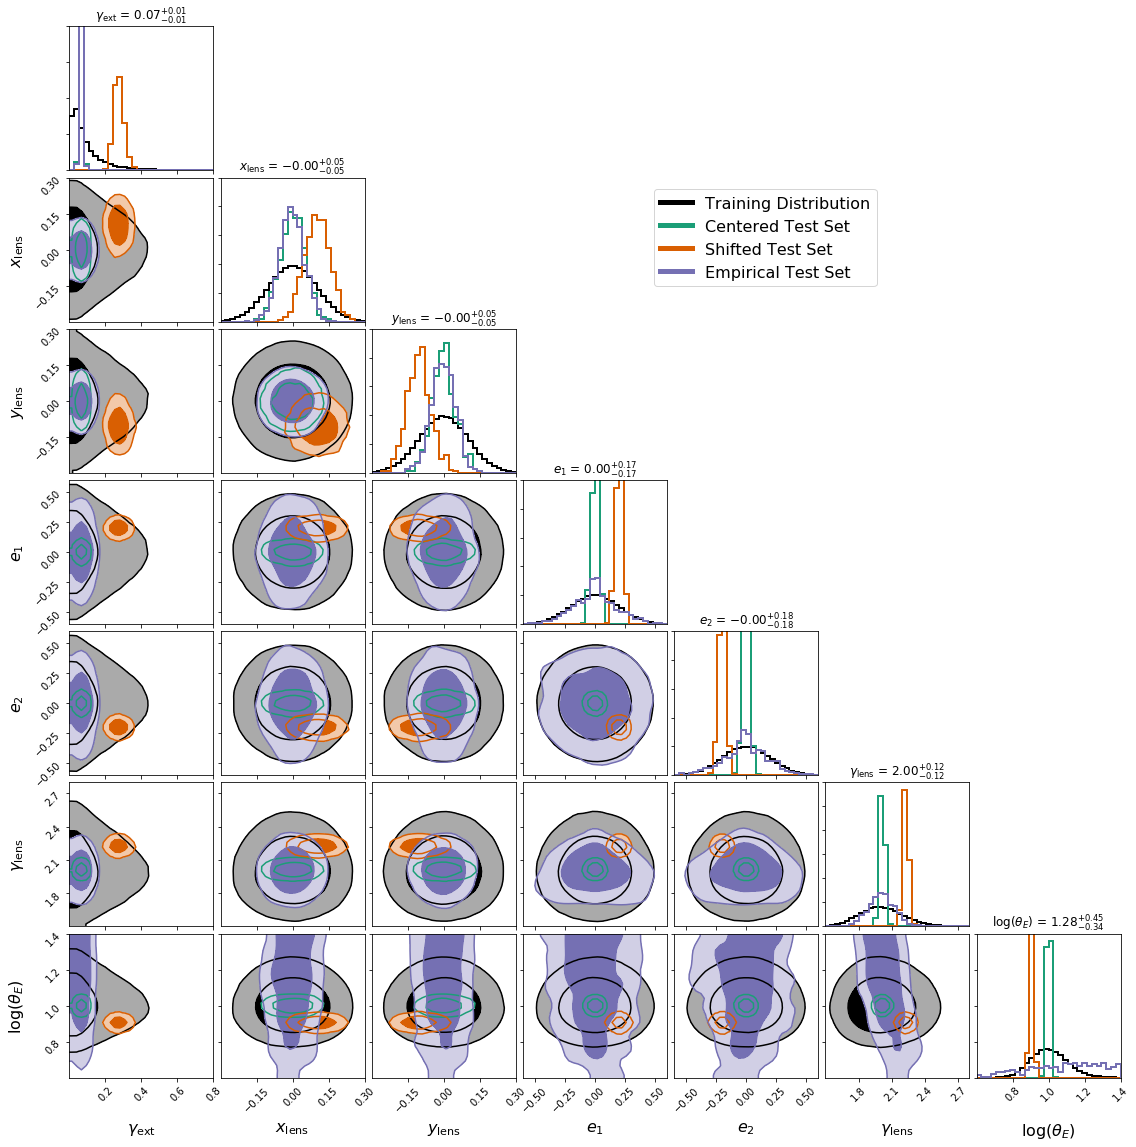

Percent of Training Points in Centered Test Set:  0.14425
Number of Training Points in Centered Test Set:  577
Percent of Training Points in Shifted Test Set:  0.0055000000000000005
Number of Training Points in Shifted Test Set:  22
Percent of Training Points in Empirical Test Set:  18.255
Number of Training Points in Empirical Test Set:  73020


In [2]:
# Load each one of the metadatas to compare the corner plots
root_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/'
train_metadata = pd.read_csv(root_path+'datasets/train/metadata.csv')
cn_metadata = pd.read_csv(root_path+'datasets/cent_narrow/metadata.csv')
sn_metadata = pd.read_csv(root_path+'datasets/shifted_narrow/metadata.csv')
emp_metadata = pd.read_csv(root_path+'datasets/empirical/metadata.csv')

# Specify the lens_params we're interested in
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
lens_params = cfg['dataset_params']['lens_params']
final_params_print_names = cfg['inference_params']['final_params_print_names']
final_params_print_names.pop(lens_params.index('external_shear_psi_ext'))
final_params_print_names[0] = r'$\gamma_\mathrm{ext}$'
lens_params.pop(lens_params.index('external_shear_psi_ext'))

# Get the samples in numpy format
train_samps = train_metadata[lens_params].to_numpy()
cn_samps = cn_metadata[lens_params].to_numpy()
sn_samps = sn_metadata[lens_params].to_numpy()
emp_samps = emp_metadata[lens_params].to_numpy()

# Generate the plot
figure= None
color_map = ['000000','#1b9e77','#d95f02','#7570b3']
plot_limits = [[0,0.8],[-0.3,0.3],[-0.3,0.3],[-0.6,0.6],[-0.6,0.6],[1.5,2.8],[0.6,1.4]]
hist_limit = [20,10,10,10,10,15,20]
smooth = 0.8
fontsize = 16
hist_kwargs = {'density':True,'color':color_map[0],'lw':2}
figure = corner.corner(train_samps,labels=final_params_print_names,bins=30,show_titles=True, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map[0],levels=[0.68,0.95],fill_contours=True,
                       fig=figure,range=plot_limits,smooth=smooth,hist_kwargs=hist_kwargs)
hist_kwargs['color']=color_map[1]
figure = corner.corner(cn_samps,labels=final_params_print_names,bins=30,show_titles=True, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map[1],levels=[0.68,0.95],fill_contours=True,
                       fig=figure,range=plot_limits,smooth=smooth,hist_kwargs=hist_kwargs)
hist_kwargs['color']=color_map[2]
figure = corner.corner(sn_samps,labels=final_params_print_names,bins=30,show_titles=True, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map[2],levels=[0.68,0.95],fill_contours=True,
                       fig=figure,range=plot_limits,smooth=smooth,hist_kwargs=hist_kwargs)
hist_kwargs['color']=color_map[3]
figure = corner.corner(emp_samps,labels=final_params_print_names,bins=30,show_titles=True, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map[3],levels=[0.68,0.95],fill_contours=True,
                       fig=figure,range=plot_limits,smooth=smooth*2,hist_kwargs=hist_kwargs)
handles = [Line2D([0], [0], color=color_map[0], lw=5),
           Line2D([0], [0], color=color_map[1], lw=5),
           Line2D([0], [0], color=color_map[2], lw=5),
           Line2D([0], [0], color=color_map[3], lw=5)]
figure.legend(handles,[r'Training Distribution', r'Centered Test Set',r'Shifted Test Set',r'Empirical Test Set'],
              loc=(0.575,0.75),fontsize=fontsize)

axes = np.array(figure.axes).reshape((len(lens_params),len(lens_params)))
for i in range(len(lens_params)):
    axes[i,i].set_ylim(0,hist_limit[i])
    
plt.savefig('figures/distribution_comp.pdf')
plt.show()

print('Percent of Training Points in Centered Test Set: ',
      np.mean(np.prod((train_samps > np.min(cn_samps,axis=0)) * (train_samps < np.max(cn_samps,axis=0)),axis=1))*100)
print('Number of Training Points in Centered Test Set: ',
      np.sum(np.prod((train_samps > np.min(cn_samps,axis=0)) * (train_samps < np.max(cn_samps,axis=0)),axis=1)))
print('Percent of Training Points in Shifted Test Set: ',
      np.mean(np.prod((train_samps > np.min(sn_samps,axis=0)) * (train_samps < np.max(sn_samps,axis=0)),axis=1))*100)
print('Number of Training Points in Shifted Test Set: ',
      np.sum(np.prod((train_samps > np.min(sn_samps,axis=0)) * (train_samps < np.max(sn_samps,axis=0)),axis=1)))
print('Percent of Training Points in Empirical Test Set: ',
      np.mean(np.prod((train_samps > np.min(emp_samps,axis=0)) * (train_samps < np.max(emp_samps,axis=0)),axis=1))
      *100)
print('Number of Training Points in Empirical Test Set: ',
      np.sum(np.prod((train_samps > np.min(emp_samps,axis=0)) * (train_samps < np.max(emp_samps,axis=0)),axis=1)))


In [ ]:
# Diagonal model 30% dropout chains on centered test distribution
# Specify the paths for our distribution configs, the test set, and the location on the saved BNN samples and chains
root_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/'
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_ovejero_omega_path = root_path + 'configs/baobab_configs/empirical_prior.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/empirical.py'
test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/empirical/'
test_dataset_tf_record_path = test_dataset_path + 'tf_record_emp'
num_samples = 1000
n_walkers = 100

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
train_to_test_param_map = dict(orig_params=['lens_mass_e1','lens_mass_e2'],transform_func=ellipticity2phi_q,
                               new_params=['lens_mass_phi','lens_mass_q'])
hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path,
                                                             train_to_test_param_map=train_to_test_param_map)

# We can load the chains for nn1_hr on the centered narrow distribution
save_path_samples_nn3_slr = root_path + 'hierarchical_results/emp_nn3_slr_samps/'
hier_infer_nn3.gen_samples(num_samples,save_path_samples_nn3_slr)
# Same goes for the samples
n_walkers = 50
save_path_chains_nn3_slr = root_path + 'hierarchical_results/emp_nn3_slr.h5'
pool = Pool()
hier_infer_nn3.initialize_sampler(n_walkers,save_path_chains_nn3_slr)
num_samples = 10000
hier_infer_nn3.run_sampler(num_samples,progress=True)

Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn3_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/empirical/tf_record_emp
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/emp_nn3_slr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/emp_nn3_slr_samps/
No chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/emp_nn3_slr.h5


  0%|          | 11/10000 [01:39<26:57:39,  9.72s/it]

## Compare performance of all three model types on the centered narrow test distribution

First, we start by loading the files we'll need for our analysis

In [3]:
# Here we'll define a few lists we'll use throughout plotting
hyperparam_plot_names = [r'$\mu_{\gamma_\mathrm{ext}}$',r'$\sigma_{\gamma_\mathrm{ext}}$',
                         r'$\mu_\psi$',r'$\alpha_\psi$',r'$p_\psi$',
                         r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$\mu_{e1}$',r'$\sigma_{e1}$',
                         r'$\mu_{e2}$',r'$\sigma_{e2}$',
                         r'$\mu_{\gamma_\mathrm{lens}}$',r'$\sigma_{\gamma_\mathrm{lens}}$',
                         r'$\mu_{\theta_E}$',r'$\sigma_{\theta_E}$']
param_plot_names = [r'$\gamma_\mathrm{ext}$', r'$\psi_\mathrm{ext}$',r'$x_\mathrm{lens}$',
            r'$y_\mathrm{lens}$',r'$e_1$',r'$e_2$',r'$\gamma_\mathrm{lens}$',r'$\theta_E$']

In [18]:
# Diagonal model 30% dropout chains on centered test distribution
# Specify the paths for our distribution configs, the test set, and the location on the saved BNN samples and chains
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_ovejero_omega_path = root_path + 'configs/baobab_configs/cent_narrow_cfg_prior.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/cent_narrow.py'
test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/'
test_dataset_tf_record_path = test_dataset_path + 'tf_record_cn'
num_samples = 1000
n_walkers = 50

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn1 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)

# We can load the chains for nn1_hr on the centered narrow distribution
save_path_samples_cn_nn1_hr = root_path + 'hierarchical_results/cn_nn1_hr_samps/'
hier_infer_nn1.gen_samples(num_samples,save_path_samples_nn1_hr)
# Same goes for the samples
n_walkers = 50
save_path_chains_nn1_hr = root_path + 'hierarchical_results/cn_nn1_hr.h5'
hier_infer_nn1.initialize_sampler(n_walkers,save_path_chains_nn1_hr)

# Repeat this process for our remaining trow distributions
# Full Model 0.1% Dropout
# config_path = root_path + 'configs/nn2_slr.json'
# cfg = model_trainer.load_config(config_path)
# recursive_str_checker(cfg)
# hier_infer_nn2 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
#                                                              test_dataset_path,test_dataset_tf_record_path,
#                                                              target_baobab_omega_path=target_baobab_omega_path)
# save_path_samples_nn2_slr = root_path + 'hierarchical_results/cn_nn2_slr_samps/'
# hier_infer_nn2.gen_samples(num_samples,save_path_samples_nn2_slr)
# save_path_chains_nn2_slr = root_path + 'hierarchical_results/cn_nn2_slr.h5'
# hier_infer_nn2.initialize_sampler(n_walkers,save_path_chains_nn2_slr)

# GMM Model 0.1% Dropout
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr_samps/'
hier_infer_nn3.gen_samples(num_samples,save_path_samples_nn3_slr)
save_path_chains_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr.h5'
hier_infer_nn3.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn1_hr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn1_hr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn1_hr_samps/
Loaded chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn1_hr.h5
Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn3_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr_samps/
Loading samples from /Users/sebwagner/Doc

We can quickly check that each of our chains are converged. These lines are commented out to avoid extending the length of notebook, but you should run them at least once!

In [75]:
# hier_infer_nn1.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# chains = hier_infer_nn1.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn2.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# chains = hier_infer_nn2.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# chains = hier_infer_nn3.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)
burnin = 8000

## NN2_HR

In [ ]:
# First specify the config path
config_path = root_path + 'configs/nn2_slr.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)
num_samples = 1000
save_path_samples_nn2_slr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                            'hierarchical_results/cn_nn2_slr_samps/')
hier_infer.gen_samples(num_samples,save_path_samples_nn2_slr)

In [ ]:
n_walkers = 50
save_path_chains_nn2_slr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                           'hierarchical_results/cn_nn2_slr.h5')
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn2_slr)

In [ ]:
hier_infer.plot_chains(burnin=None,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
burnin = 6000
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
hier_infer.plot_corner(burnin,hyperparam_plot_names,color='#d95f02')

In [ ]:
color_map = ['#d95f02',"#41b6c4","#2c7fb8","#253494"]
bnn_name = 'Full BNN'
hier_infer.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name)

In [ ]:
hier_infer.gen_samples(num_samples,save_path_samples)
hier_infer.initialize_sampler(n_walkers,save_path_chains)
n_perc_points = 30
n_p_omega_samps = 100
legend = ['Perfect Calibration','Bare Network','Reweighted Network']
hier_infer.plot_reweighted_calibration(burnin,n_perc_points,n_p_omega_samps=n_p_omega_samps,legend=legend)

## NN3_LR

In [ ]:
# First specify the config path
config_path = root_path + 'configs/nn3_slr.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)
num_samples = 1000
save_path_samples_nn3_slr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                            'hierarchical_results/cn_nn3_slr_samps/')
hier_infer.gen_samples(num_samples,save_path_samples_nn3_slr)

In [ ]:
n_walkers = 50
save_path_chains_nn3_slr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                           'hierarchical_results/cn_nn3_slr.h5')
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

In [ ]:
hier_infer.plot_chains(burnin=None,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
burnin = 6000
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
hier_infer.plot_corner(burnin,hyperparam_plot_names,color='#7570b3')

In [ ]:
color_map = ['#7570b3',"#41b6c4","#2c7fb8","#253494"]
bnn_name = 'GMM BNN'
hier_infer.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name)

In [ ]:
# image_index = 20
# # plot_limits = [(-0.07,0.05),(-0.12,0.0),(-0.08,0.00),(-0.08,0.00),(-0.15,0.15),(-0.15,0.15),(1.8,2.2),
# #               (-0.05,0.05)]
# hier_infer.plot_reweighted_lens_posterior(burnin,image_index,plot_limits=None)

In [ ]:
n_perc_points = 30
n_p_omega_samps = 100
legend = ['Perfect Calibration','Bare Network','Reweighted Network']
hier_infer.plot_reweighted_calibration(burnin,n_perc_points,n_p_omega_samps=n_p_omega_samps,legend=legend)

## NN1_HR and NN3_LR Direct Comparison

In [ ]:
# Plot the two contours with the truth
plot_param = 'lens_mass_gamma'
hier_infer.gen_samples(num_samples,save_path_samples_nn1_hr)
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn1_hr)
figure = hier_infer.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77')
hier_infer.gen_samples(num_samples,save_path_samples_nn2_slr)
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn2_slr)
figure = hier_infer.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure)
hier_infer.gen_samples(num_samples,save_path_samples_nn3_slr)
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn3_slr)
figure = hier_infer.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure)

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.show(figure)

# Shifted Narrow

## NN1_HR

In [ ]:
# First specify the config path
root_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/'
config_path = root_path + 'configs/nn1_hr.json'

# We also need the path to the baobab configs for the interim and target omega
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/shifted_narrow_cfg_prior.py'

test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/shifted_narrow/'
test_dataset_rf_record_path = test_dataset_path + 'tf_record_sn'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)

# Now we just have to ask the InferenceClass to spin up some samples from our BNN. The more samples, the more
# accurate our plots and metrics will be. The right value to use unfortunately requires a bit of trial and error.
# 100 is a good starting point though.
num_samples = 1000
save_path_samples_nn1_hr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                     'hierarchical_results/sn_nn1_hr_samps/')
hier_infer.gen_samples(num_samples,save_path_samples_nn1_hr)

In [ ]:
n_walkers = 50
save_path_chains_nn1_hr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                           'hierarchical_results/sn_nn1_hr.h5')
pool = Pool()
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn1_hr,pool=pool)

In [ ]:
burnin=8000
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
burnin = 6000
color_map = ['#1b9e77',"#41b6c4","#2c7fb8","#253494"]
bnn_name = 'Diagonal BNN'
hier_infer.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name)

## NN2_HR

In [ ]:
# First specify the config path
config_path = root_path + 'configs/nn2_slr.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)
num_samples = 1000
save_path_samples_nn2_slr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                            'hierarchical_results/sn_nn2_slr_samps/')
hier_infer.gen_samples(num_samples,save_path_samples_nn2_slr)

In [ ]:
n_walkers = 50
save_path_chains_nn2_slr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                           'hierarchical_results/sn_nn2_slr.h5')
pool = Pool()
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn2_hr,pool=pool)

In [ ]:
burnin=8000
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
burnin = 6000
color_map = ['#d95f02',"#41b6c4","#2c7fb8","#253494"]
bnn_name = 'Full BNN'
hier_infer.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name)

## NN3_LR

In [ ]:
# First specify the config path
config_path = root_path + 'configs/nn3_slr.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)
num_samples = 1000
save_path_samples_nn3_slr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                            'hierarchical_results/sn_nn3_slr_samps/')
hier_infer.gen_samples(num_samples,save_path_samples_nn3_slr)

In [ ]:
n_walkers = 50
save_path_chains_nn3_slr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                           'hierarchical_results/sn_nn3_slr.h5')
pool = Pool()
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn3_slr,pool=pool)

In [ ]:
burnin=9000
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

In [ ]:
burnin = 6000
color_map = ['#7570b3',"#41b6c4","#2c7fb8","#253494"]
bnn_name = 'GMM BNN'
hier_infer.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name)

## Direct Comparison

In [ ]:
# Plot the two contours with the truth
burnin=9000
plot_param = 'lens_mass_gamma'
hier_infer.gen_samples(num_samples,save_path_samples_nn1_hr)
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn1_hr)
figure = hier_infer.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77')
hier_infer.gen_samples(num_samples,save_path_samples_nn2_slr)
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn2_slr)
figure = hier_infer.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure)
hier_infer.gen_samples(num_samples,save_path_samples_nn3_slr)
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn3_slr)
figure = hier_infer.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure)

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.show(figure)

In [ ]:
# Plot the two contours with the truth
plot_param = 'external_shear_gamma_ext'
hier_infer.gen_samples(num_samples,save_path_samples_nn1_hr)
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn1_hr)
figure = hier_infer.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77')
hier_infer.gen_samples(num_samples,save_path_samples_nn2_hr)
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn2_hr)
figure = hier_infer.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure)
hier_infer.gen_samples(num_samples,save_path_samples_nn3_lr)
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn3_lr)
figure = hier_infer.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure)

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (5%)',r'GMM BNN (0.5%)'],
              loc=(0.575,0.75))
plt.show(figure)

# Comparison of Number of Lens Samples

In [ ]:
hier_infer.gen_samples(num_samples,root_path+'hierarchical_results/sn_nn3_lr_samps/')
hier_infer.initialize_sampler(n_walkers,root_path+'hierarchical_results/sn_nn3_lr.h5')
burnin = 6000
color_map = ['#7570b3',"#41b6c4","#2c7fb8","#253494"]
bnn_name = 'GMM BNN'
hier_infer.plot_distributions(2000,param_plot_names,color_map=color_map,bnn_name=bnn_name)

In [ ]:
# Plot the two contours with the truth
plot_param = 'lens_mass_gamma'

hier_infer.gen_samples(num_samples,root_path+'hierarchical_results/sn_nn3_lr_samps/')
hier_infer.initialize_sampler(n_walkers,root_path+'hierarchical_results/sn_nn3_lr.h5')
figure = hier_infer.plot_single_corner(2000,plot_param,hyperparam_plot_names,color='#1b9e77')
hier_infer.gen_samples(num_samples,root_path+'hierarchical_results/sn_nn3_lr_samps/')
hier_infer.initialize_sampler(n_walkers,root_path+'hierarchical_results/sn_nn3_lr_100.h5')
figure = hier_infer.plot_single_corner(8000,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure)
hier_infer.gen_samples(num_samples,root_path+'hierarchical_results/sn_nn3_lr_samps/')
hier_infer.initialize_sampler(n_walkers,root_path+'hierarchical_results/sn_nn3_lr_50.h5')
figure = hier_infer.plot_single_corner(8000,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure)

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'GMM BNN (0.1%) All Lenses', r'GMM BNN (0.1%) 100 Lenses',r'GMM BNN (0.1%) 50 Lenses'],
              loc=(0.575,0.75))
plt.show(figure)

In [ ]:
# Plot the two contours with the truth
plot_param = 'lens_mass_gamma'
plot_range = [[0.695,0.705],[0.005,0.014]]

# We also need the path to the baobab configs for the interim and target omega
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/cent_narrow_cfg_prior.py'

test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/'
test_dataset_rf_record_path = test_dataset_path + 'tf_record_cn'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)

hier_infer.gen_samples(num_samples,root_path+'hierarchical_results/cn_nn3_samps/')
hier_infer.initialize_sampler(n_walkers,root_path+'hierarchical_results/cn_nn3.h5')
figure = hier_infer.plot_single_corner(2000,plot_param,hyperparam_plot_names,color='#1b9e77',plot_range=plot_range)
hier_infer.gen_samples(num_samples,root_path+'hierarchical_results/cn_nn3_lr_samps/')
hier_infer.initialize_sampler(n_walkers,root_path+'hierarchical_results/cn_nn3_lr.h5')
figure = hier_infer.plot_single_corner(8000,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure,
                                      plot_range=plot_range)
hier_infer.gen_samples(num_samples,root_path+'hierarchical_results/cn_nn3_slr_samps/')
hier_infer.initialize_sampler(n_walkers,root_path+'hierarchical_results/cn_nn3_slr.h5')
figure = hier_infer.plot_single_corner(8000,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure,
                                      plot_range=plot_range)

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'GMM BNN (1%)', r'GMM BNN (0.5%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.show(figure)

In [ ]:
root_path

In [ ]:
# First specify the config path
config_path = root_path + 'configs/nn3_lr.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)
num_samples = 1000
save_path_samples_nn3_lr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                            'hierarchical_results/sn_nn3_lr_samps/')
hier_infer.gen_samples(num_samples,save_path_samples_nn3_lr)

In [ ]:
n_walkers = 50
save_path_chains_nn3_lr = ('/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/' + 
                           'hierarchical_results/sn_nn3_lr.h5')
hier_infer.initialize_sampler(n_walkers,save_path_chains_nn3_lr)